# Transfer Learning with TensorFlow - Part 2: Fine-tuning

In the previous notebook, we covered transfer learning feature extraction, now it's time to learn about a new kind of transfer learning: fine-tuning.

In [1]:
# Check if we're using a GPU
!nvidia-smi

Tue Aug 30 11:04:10 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

IN the previous notebooks, we're created a bunch of helper functions. Now we could rewrite them all, however, this is tedious.

So, it's a good idea to put functions you'll want to use again in a script you can download and import into your notebooks (or elsewhere).


We're done this for some of the functions we're used previously here:

https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-08-30 11:04:10--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-08-30 11:04:11 (83.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import hepler functions we're going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

🔑 **Note:** If you're running this notebook in Google Colab, when it times out Colab will delete `helper_functions.py`, so you'll have to redownload it if you want access to your helper functions.

## Let's get some data

This time we're going to see how we can use the pretrained models wthin `tf.keras,applications` and apply them to our own problem (recognizing images of food).

Link: https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [4]:
# Get 10% of training data of 10 classes of Food101

! wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2022-08-30 11:04:14--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.12.128, 172.217.194.128, 142.250.4.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.12.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   256MB/s    in 0.6s    

2022-08-30 11:04:15 (256 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ch

In [6]:
# Create training and test directory paths
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [7]:
import tensorflow as tf 

In [8]:
IMG_SIZE=(224, 224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode = "categorical",
                                                                batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [9]:
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [10]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [11]:
# See an example of a batch of data
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[255.         252.5153     228.58673   ]
   [255.         253.61734    229.35715   ]
   [255.         253.         228.71428   ]
   ...
   [ 35.85723      0.35714287   7.219402  ]
   [ 40.76016      1.9744852    6.9030433 ]
   [ 34.341743     0.           1.0560652 ]]

  [[252.92857    250.94897    230.04591   ]
   [254.79082    252.85205    231.92857   ]
   [254.         253.         232.21428   ]
   ...
   [ 39.12764      4.5561676   10.7704315 ]
   [ 40.93875      4.938751     8.938751  ]
   [ 36.59687      2.5968714    3.5968714 ]]

  [[250.70918    250.56633    232.21428   ]
   [251.4847     251.91327    233.5       ]
   [252.7653     252.83163    236.57143   ]
   ...
   [ 38.142967     3.5714939    9.785758  ]
   [ 41.158154     5.158153     9.045887  ]
   [ 39.57647      6.137748     7.137748  ]]

  ...

  [[133.31123     85.02042     81.250015  ]
   [133.32143     85.89284     78.249985  ]
   [139.1684      92.7398      79.52552   ]
   ...
   [ 71.33667     35.336

## Model 0:Building a transfer learning feature extraction model using the Keras Functional API

The Sequential API is straight-forward, it runs our layers in sequential order.

Yet the functional API gives us more flexibility with our models.

In [12]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the underlying pre-trained patterns aren't updated during training)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using a model like ResNet50V2 you will need to normalize inputs (you don't have to for EfficientNet)
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 10.  Fit the model
history_10_percent = model_0.fit(train_data_10_percent,
                              epochs=5,
                              steps_per_epoch=len(train_data_10_percent),
                              validation_data=test_data,
                              validation_steps=int(0.25 * len(test_data)),
                              callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                     experiment_name="10_percent_feature_extraction_model_0")])

16719872/16705208 [==============================] - 1s 0us/step
Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction_model_0/20220830-110428
Epoch 1/5
24/24 [==============================] - 27s 287ms/step - loss: 1.9214 - accuracy: 0.3760 - val_loss: 1.3734 - val_accuracy: 0.6809
Epoch 2/5
24/24 [==============================] - 4s 155ms/step - loss: 1.1587 - accuracy: 0.7427 - val_loss: 0.9469 - val_accuracy: 0.7714
Epoch 3/5
24/24 [==============================] - 5s 185ms/step - loss: 0.8480 - accuracy: 0.7960 - val_loss: 0.7230 - val_accuracy: 0.8355
Epoch 4/5
24/24 [==============================] - 4s 154ms/step - loss: 0.6857 - accuracy: 0.8387 - val_loss: 0.6509 - val_accuracy: 0.8289
Epoch 5/5
24/24 [==============================] - 4s 155ms/step - loss: 0.5938 - accuracy: 0.8613 - val_loss: 0.5847 - val_accuracy: 0.8438


In [13]:
# Evaluate on the full dataset
model_0.evaluate(test_data)

79/79 [==============================] - 7s 78ms/step - loss: 0.6052 - accuracy: 0.8424


[0.6051958203315735, 0.8424000144004822]

In [14]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [15]:
# Get a summary of the base model
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [16]:
# Summary of our whole model
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


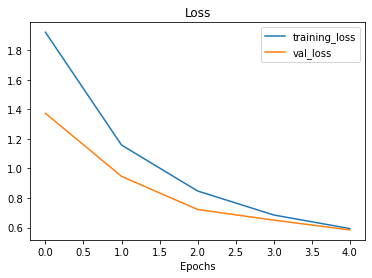

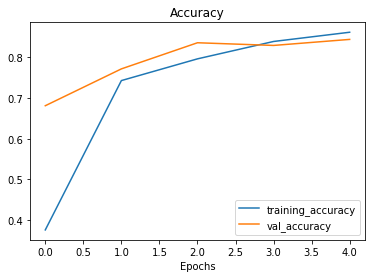

In [17]:
# Check out our model's training curves
plot_loss_curves(history_10_percent)

## Getting a feature vector from a trained model

Let's demonstrate the Global Average Pooling 2D layer ...

We have a tensor after our model goes through `base_model` of shape (None, 7, 7, 1280).

But then when it passes through `GlobalAveragePooling2D`, it turns into (None, 1280).

Let's use a similar shaped tensor of (1, 4,4,3) and then pass it to `GlobalAveragePooling2D`. 

In [18]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]



In [19]:
# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]



In [20]:
# Check the shape of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}\n")
print(f"Shape of Global Average Pooled 2D tenosr: {global_average_pooled_tensor.shape}")

Shape of input tensor: (1, 4, 4, 3)

Shape of Global Average Pooled 2D tenosr: (1, 3)


In [21]:
# Let's replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

⛏ **Practice:** Do the same with the above cells, but this time use `GlobalMaxPool2D` ... & compare the results

In [22]:
# Pass the random tensor through a global max poolin 2D layer
global_max_pooled_tensor = tf.keras.layers.GlobalMaxPool2D()(input_tensor)
print(f"2D Global Max Pooled Random tensor:\n {global_max_pooled_tensor}")

# Check the shape of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of Global Average Pooled 2D tensor: {global_average_pooled_tensor.shape}")
print(f"Shape of Global Max Pooled 2D tensor: {global_max_pooled_tensor.shape}")

2D Global Max Pooled Random tensor:
 [[0.9058464 1.1603122 1.6994323]]
Shape of input tensor: (1, 4, 4, 3)
Shape of Global Average Pooled 2D tensor: (1, 3)
Shape of Global Max Pooled 2D tensor: (1, 3)


🔑 **Note:** One of the reasons feature extraction transfer learning is named how it is because what often happens is pretrained model outputs a **feature vector** (a long tensor of numbers which reprsents the learned representation of the model on a particular sample, in our case, this is the output of the `tf.keras.layers.GlobalAveragePooling2D()` layer) which can then be used to extract patterns out of for our own specific problem.

## Running a series of transfer learning experiments

We're seen the incredible results transferlearning can get with only 10% of the training data, but how does it go with 1% of the training data ... how about we set up a bunch of experiments to find out: 

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation.
2. `model_2` - use feature extraction transfer learning with 10% of the training with data augmentation.
3. `model_3` - use fine-tuning transfer learning on 10% of the training data with data augmentation.
4. `model_4` - use fine-tuning transfer learning on 100% of the training data with data augmentation.

> 🔑 **Note:** throughout all experiments the same test dataset will be used to evaluate our model ... this ensures consistency across evaluation metrics. 

### Getting and preprocessing data for `model_1`

In [23]:
# Download and unzip data - preprocessed from Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

unzip_data("10_food_classes_1_percent.zip")


--2022-08-30 11:05:26--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.128, 74.125.130.128, 74.125.68.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  56.5MB/s    in 2.3s    

2022-08-30 11:05:29 (56.5 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [24]:
# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train"
test_data = "10_food_classes_1_percent/test"

In [25]:
# How many images are we working with?
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'

In [26]:
# Setup data loaders
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           image_size = IMG_SIZE,
                                                                           batch_size = BATCH_SIZE)

test_data =tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                               label_mode = "categorical",
                                                               image_size = IMG_SIZE,
                                                               batch_size = BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model


To add data augmentation right into our models, we can use the layers inside:

* `tf.keras.layers.experimental.preprocessing()`

We can see the benefits of doing this within the TensorFlow Data augmentation documentation: https://www.tensorflow.org/tutorials/images/data_augmentation#use_keras_preprocessing_layers

Off the top of heads, after reading the docs, the benefits of using data augmentation inside the model are:
* Preprocessing of images (augmenting them) happends on the GPU (much faster) rather than the CPU.
* Image data augmentation only happens during training, so we can still export our whole model and use it elsewhere.

In [27]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [28]:
# Create data augmentation stage with horizontal flipping, rorations, zooms, etc.
data_augmentation = tf.keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    # preprocessing.Rescale(1./255) # Keep for models like ResNet50V2 but EfficientNet's having rescaling built-in
    ], name="data_augmentation")

### Visualize our data augmentation layer (and see what happens to our data) 

In [29]:
# View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

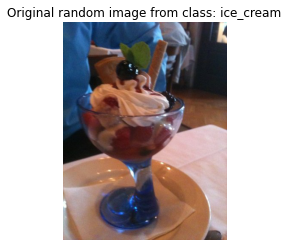

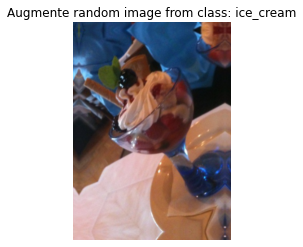

In [30]:
target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read and plot in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class: {target_class}")
plt.axis(False);

# Now let's plot our augmented random image
augmented_img = data_augmentation(img, training = True)
plt.figure()
plt.imshow(augmented_img / 255.)
plt.title(f"Augmente random image from class: {target_class}")
plt.axis(False);
# print(augmented_img)

## Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

In [31]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = tf.keras.layers.Input(shape=input_shape, name="inputLayer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name="globalAveragePoolingLayer")(x)

# Put a dense layer on as the output
outputs = tf.keras.layers.Dense(10, activation="softmax", name = "outputLayer")(x)

# Make a model using the inputs and outputs
model_1 = tf.keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                              epochs= 5,
                              steps_per_epoch=len(train_data_1_percent),
                              validation_data=test_data,
                              validation_steps=int(0.25 * len(test_data)),
                              # Track model training logs
                              callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                    experiment_name="1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20220830-110534
Epoch 1/5


3/3 [==============================] - ETA: 0s - loss: 2.4506 - accuracy: 0.1143

3/3 [==============================] - 12s 2s/step - loss: 2.4506 - accuracy: 0.1143 - val_loss: 2.2247 - val_accuracy: 0.1859
Epoch 2/5
3/3 [==============================] - 4s 2s/step - loss: 2.1427 - accuracy: 0.2714 - val_loss: 2.1179 - val_accuracy: 0.2385
Epoch 3/5
3/3 [==============================] - 4s 2s/step - loss: 1.9954 - accuracy: 0.3571 - val_loss: 2.0156 - val_accuracy: 0.3059
Epoch 4/5
3/3 [==============================] - 3s 1s/step - loss: 1.8205 - accuracy: 0.5429 - val_loss: 1.9011 - val_accuracy: 0.3914
Epoch 5/5
3/3 [==============================] - 3s 1s/step - loss: 1.6764 - accuracy: 0.6286 - val_loss: 1.8409 - val_accuracy: 0.4194


In [32]:
# Check out a model summary
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, 3)          0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 globalAveragePoolingLayer (  (None, 1280)             0         
 GlobalAveragePooling2D)                                         
                                                                 
 outputLayer (Dense)         (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [33]:
# Evaluate on the full test dataset
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 6s 75ms/step - loss: 1.8334 - accuracy: 0.4160


[1.8334364891052246, 0.41600000858306885]

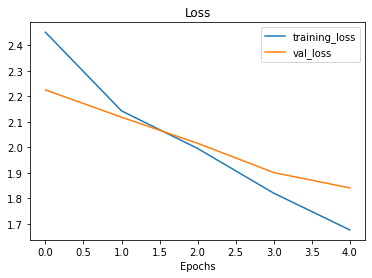

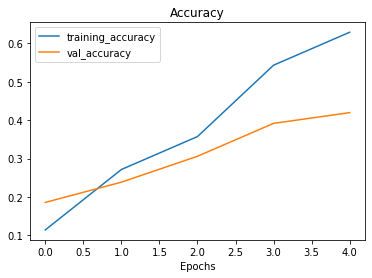

In [34]:
# Plot the loss curves for 1% data augmentation
plot_loss_curves(history_1_percent)

## Model 2: feature extraction transfer learning model with 10% of data and data augmentation 

In [35]:
train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [36]:
# How many images are in our directories?
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ch

In [37]:
# Set up data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode = "categorical")

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [38]:
data_augmentation.summary()

Model: "data_augmentation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (512, 384, 3)             0         
                                                                 
 random_rotation (RandomRota  (512, 384, 3)            0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (512, 384, 3)             0         
                                                                 
 random_height (RandomHeight  (None, 384, 3)           0         
 )                                                               
                                                                 
 random_width (RandomWidth)  (None, None, 3)           0         
                                                                 
Total params: 0
Trainable params: 0
Non-trainable

In [39]:
# Create model_2 with data augmentation built in
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build data augmentation layer
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2),
    # preprocessing.Rescaling(1./255) # if you're using a model such as ResNet50V2, you'll need to rescale your data, Effinet has rescaling built-in
], name = "dataAugmentation")

In [40]:
# Setup the input shape to our model
input_shape = (224, 224, 3)

# Create a frozen base model (also called the backbone)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create the inputs and outps (including the layers in between)
inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs) # augment our training images (augmentation doesn't occur on test data)
x = base_model(x, training=False) # pass the augmented images to base model but keep it in inference mode, this also insures batchnorm layers don't get updated
x = layers.GlobalAveragePooling2D(name="global_average_pooling_2D")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [41]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 dataAugmentation (Sequentia  (None, 224, 224, 3)      0         
 l)                                                              
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_2D (  (None, 1280)             0         
 GlobalAveragePooling2D)                                         
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [42]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


### Creating a ModelCheckpoint callback

The `ModelCheckpoint` callback intermediately saves our model (the full model or just the weights) during training. This is useful so we can come back and start where we left off. 

In [43]:
# Set checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                                         save_weights_only = True,
                                                         save_best_only=False,
                                                         save_freq = "epoch", # save every epoch
                                                         verbose=1)

### Fit model 2 passing in the ModelCheckpoint callback

In [44]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          steps_per_epoch=len(train_data_10_percent),
                                          validation_data=test_data,
                                          validation_steps=int(0.25*len(test_data)),
                                          callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                 experiment_name="10_percent_data_aug"),
                                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20220830-110617
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9955 - accuracy: 0.3320
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 19s 523ms/step - loss: 1.9955 - accuracy: 0.3320 - val_loss: 1.4807 - val_accuracy: 0.6809
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3300 - accuracy: 0.6907
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 10s 412ms/step - loss: 1.3300 - accuracy: 0.6907 - val_loss: 1.0210 - val_accuracy: 0.7747
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0264 - accuracy: 0.7613
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 10s 372ms/step - loss: 1.0264 - accuracy: 0.7613 - val_loss: 0.8415 - val_accuracy: 0.8026
E

In [45]:
# What were model_0 results?
model_0.evaluate(test_data)

79/79 [==============================] - 7s 73ms/step - loss: 0.6052 - accuracy: 0.8424


[0.6051955819129944, 0.8424000144004822]

In [46]:
# Check model_2 results on all test_data 
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 6s 73ms/step - loss: 0.6908 - accuracy: 0.8084


[0.6908438205718994, 0.8083999752998352]

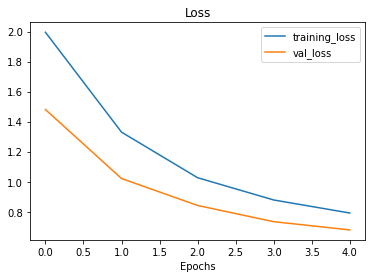

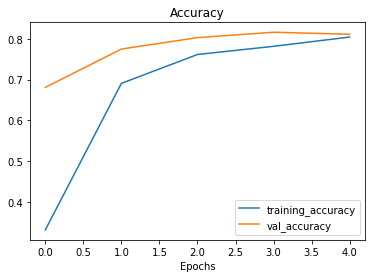

In [47]:
# Plot model loss curves
plot_loss_curves(history_10_percent_data_aug)

### Loading in checkpointed weights

Loading in checkpointed weights returns a model to a specific checkpoint.

In [48]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [49]:
# Evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 6s 73ms/step - loss: 0.6908 - accuracy: 0.8084


In [50]:
# If the results from our previously evaluated model_2 match the loaded weights, everything has worked!
results_10_percent_data_aug == loaded_weights_model_results

True

In [51]:
results_10_percent_data_aug

[0.6908438205718994, 0.8083999752998352]

In [52]:
loaded_weights_model_results

[0.6908438205718994, 0.8083999752998352]

In [53]:
# Check to see if loaed model results are very close to our previous non-loaded model results
import numpy as np
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

In [54]:
# Check the difference between the two results
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

[0. 0.]


## Model 3: Fine-tuning an existing model on 10% of the data

> 🔑 **Note:** Fine-tuning usually works best *after* training a feature eextraction model for a few epochs with large amounts of custom data.

In [55]:
# Layers in our loaded model
model_2.layers

In [56]:
# Are these layers trainable?
for layer in model_2.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fbe4b315c90> True
<keras.engine.sequential.Sequential object at 0x7fbe4b2b1f90> True
<keras.engine.functional.Functional object at 0x7fbe4ae0ae10> False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7fbe4b315c50> True
<keras.layers.core.dense.Dense object at 0x7fbe4b3520d0> True


In [60]:
# What layers are in oour base_model (EfficientNetB0) and are they trainable?
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [62]:
# How many trainable variables are  in our base model?
print(len(model_2.layers[2].trainable_variables))

0


In [63]:
# To begin fine-tuning, let's start by setting the last 10 layers of our base_model.trainable = True
base_model.trainable = True

# Freeze all layers execpt for the last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

# We have to recompile our models everytime we make a change
model_2.compile(loss="categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(lr=0.0001), # when fine-tuning you typically want to lower the learning rate by 10x
                metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


> 🔑 **Note:** When using fine-tuning it's best practice to lower your learning rate by some amount. How much? This is a hyperparameter you can tune. But a good rule of tumb is at least 10x (though different sources will claim other values).
A good resource for information on this is the ULMFit paper:
https://arxiv.org/abs/1801.06146

In [64]:
# Check which layers are tunable (trainable)
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [65]:
# Now we're unfrozen some of the layers closer to the top, how many trainable variables are there?
print(len(model_2.trainable_variables))

12


In [67]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               steps_per_epoch=len(train_data_10_percent),
                                               validation_data=test_data,
                                               validation_steps=int(0.25*len(test_data)),
                                               initial_epoch=history_10_percent_data_aug.epoch[-1], # start training from previous last epoch
                                               callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                      experiment_name="10_percent_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20220830-115136
Epoch 5/10
24/24 [==============================] - 21s 495ms/step - loss: 0.6834 - accuracy: 0.8227 - val_loss: 0.5824 - val_accuracy: 0.8240
Epoch 6/10
24/24 [==============================] - 9s 340ms/step - loss: 0.5464 - accuracy: 0.8493 - val_loss: 0.5168 - val_accuracy: 0.8438
Epoch 7/10
24/24 [==============================] - 9s 338ms/step - loss: 0.5077 - accuracy: 0.8493 - val_loss: 0.5343 - val_accuracy: 0.8240
Epoch 8/10
24/24 [==============================] - 7s 263ms/step - loss: 0.4617 - accuracy: 0.8533 - val_loss: 0.4884 - val_accuracy: 0.8454
Epoch 9/10
24/24 [==============================] - 8s 327ms/step - loss: 0.4334 - accuracy: 0.8560 - val_loss: 0.4756 - val_accuracy: 0.8470
Epoch 10/10
24/24 [==============================] - 8s 313ms/step - loss: 0.3719 - accuracy: 0.8840 - val_loss: 0.5285 - val_accuracy: 0.8339


In [68]:
# Evaluate the fine-tuned model (model_3 which is actually model_2 fine-tuned for another 5 epochs)
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 6s 72ms/step - loss: 0.4994 - accuracy: 0.8272


In [69]:
results_10_percent_data_aug

[0.6908438205718994, 0.8083999752998352]

In [70]:
results_fine_tune_10_percent

[0.499416708946228, 0.8271999955177307]

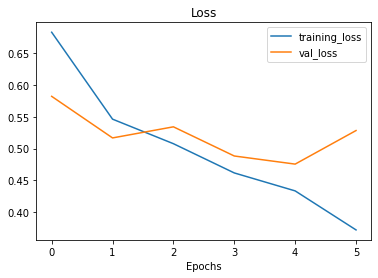

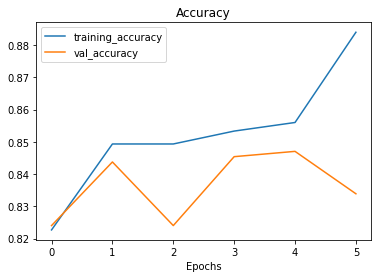

In [71]:
# Check out the loss curves of our fine-tuned model
plot_loss_curves(history_fine_10_percent_data_aug)

The `plot_loss_curves` function works great with models which have only been fit once, however, we want something to compare one series of running `fit()` with another (e.g. before and after fine-tuning).

In [76]:
# Let's create a function to compare training histories
def compare_historys(original_history, new_history, initial_epochs=5):
  """
  Compares two TensorFlow History objects."""
  # Get original history measurements
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  #Combine original history metrics with new history metrics
  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]

  total_val_acc = val_acc + new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]

  # Make plots for accuracy
  plt.figure(figsize=(8,  8))
  plt.subplot(2, 1, 1)
  plt.plot(total_acc, label="Training Accuracy")
  plt.plot(total_val_acc, label="Val Accuracy")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
  plt.legend(loc="lower right")
  plt.title("Training and Validation Accuracy")

  # Make plots for loss
  plt.figure()
  plt.figure(figsize=(8,  8))
  plt.subplot(2, 1, 2)
  plt.plot(total_loss, label="Training Loss")
  plt.plot(total_val_loss, label="Val Loss")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
  plt.legend(loc="upper right")
  plt.title("Training and Validation Loss")

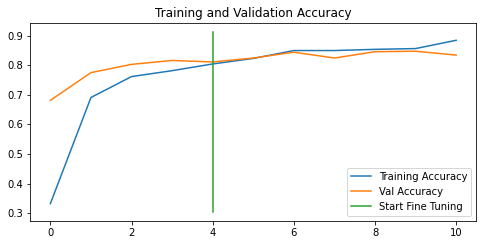

<Figure size 432x288 with 0 Axes>

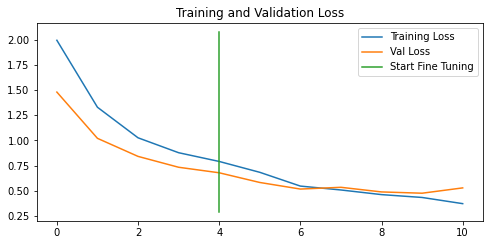

In [77]:
compare_historys(history_10_percent_data_aug,
                 history_fine_10_percent_data_aug,
                 initial_epochs=5)

## Model 4: Fine-tuning and existing model on all the data

In [78]:
# Download and unzip 10 classes of Food101 data with all images 
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

--2022-08-30 12:32:40--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.10.128, 142.251.12.128, 172.217.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.10.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  58.4MB/s    in 8.8s    

2022-08-30 12:32:49 (56.1 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [79]:
# Setup training and test dir
train_dir_all_data = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

In [80]:
# How many images are we working with now?
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 

In [81]:
# Setup data inputs
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                                 label_mode = "categorical",
                                                                                 image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


The test dataset we're loaded in is the same as what we're been using for previous experiments (all experiments have used the same test dataset).

Let's verify this ...

In [82]:
# Evaluate model 2 (this is the fine-tuned on 10 percent of data version )
model_2.evaluate(test_data)

79/79 [==============================] - 7s 76ms/step - loss: 0.4994 - accuracy: 0.8272


[0.49941641092300415, 0.8271999955177307]

In [83]:
results_fine_tune_10_percent

[0.499416708946228, 0.8271999955177307]

To train a fine-tuning model (model_4) we need to revert model_2 to its feature extraction weights.

In [84]:
# To do that, load weights from checkpoint, that way we can fine-tune from 
# the same stage the 10 percent data model was fine-tuned from. 
model_2.load_weights(checkpoint_path)


In [85]:
# Let's evaluate model_2 now 
model_2.evaluate(test_data)

79/79 [==============================] - 7s 83ms/step - loss: 0.6908 - accuracy: 0.8084


[0.6908437013626099, 0.8083999752998352]

In [86]:
# Check to see if our model_2 has been reverted back to feature extraction results
results_10_percent_data_aug

[0.6908438205718994, 0.8083999752998352]

Alright, the previous steps seem quite confusing but all we've done is:

1. Trained a feature extraction transfer learning model for 5 epochs on 10% of the data with data augmentation (model_2) and we saved the model's weights using `ModelCheckpoint` callback.
2. Fine-tuned the same model on the same 10% of the data for a further 5 epochs with the top 10 layers of the base model unfrozen (model_3).
3. Saved the results and training logs each time.
4. Reloaded the model from step 1 to do the same steps as step 2 except this time we're going to use all of the data (model_4).

In [87]:
# Check which layers are tunable in the whole model
for layer_number, layer, in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 dataAugmentation True
2 efficientnetb0 True
3 global_average_pooling_2D True
4 output_layer True


In [91]:
# Let's drill into our base_model (efficientnetB0) and see what layers are trainable
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [92]:
# Compile
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(lr=0.0001),
                metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [93]:
# Continue to train and fine-tune the model to our data (100% of training data)
fine_tune_epochs = initial_epochs + 5

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           validation_data=test_data,
                                           validation_steps=int(0.25 * len(test_data)),
                                           initial_epoch = history_10_percent_data_aug.epoch[-1],
                                           callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                  experiment_name="full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20220830-132118
Epoch 5/10
235/235 [==============================] - 63s 237ms/step - loss: 0.7240 - accuracy: 0.7659 - val_loss: 0.3745 - val_accuracy: 0.8717
Epoch 6/10
235/235 [==============================] - 46s 195ms/step - loss: 0.5962 - accuracy: 0.8068 - val_loss: 0.3392 - val_accuracy: 0.8717
Epoch 7/10
235/235 [==============================] - 44s 187ms/step - loss: 0.5213 - accuracy: 0.8285 - val_loss: 0.3247 - val_accuracy: 0.8783
Epoch 8/10
235/235 [==============================] - 42s 177ms/step - loss: 0.4861 - accuracy: 0.8464 - val_loss: 0.3058 - val_accuracy: 0.8964
Epoch 9/10
235/235 [==============================] - 41s 171ms/step - loss: 0.4543 - accuracy: 0.8525 - val_loss: 0.3230 - val_accuracy: 0.8865
Epoch 10/10
235/235 [==============================] - 37s 156ms/step - loss: 0.4206 - accuracy: 0.8637 - val_loss: 0.2879 - val_accuracy: 0.8947


In [94]:
# Let's evaluate on all of the test data
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 7s 73ms/step - loss: 0.3324 - accuracy: 0.8864


[0.3323585093021393, 0.8863999843597412]

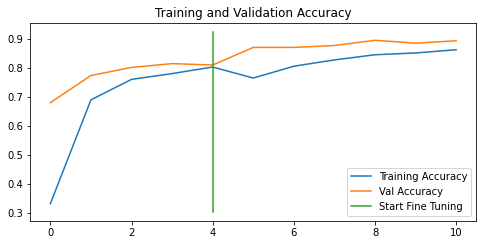

<Figure size 432x288 with 0 Axes>

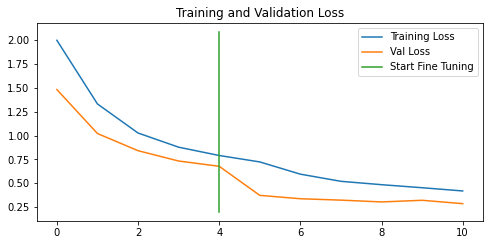

In [95]:
# How did fine-tuning go with more data?
compare_historys(original_history=history_10_percent_data_aug,
                 new_history=history_fine_10_classes_full,
                 initial_epochs=5)

## Viewing our experiment data on TensorBoard

> 🔑 **Note:** Anything you upload to TensorBoard.dev is going to be public. So if you have private data, do not upload.

In [ ]:
# View tensorboard logs of transfer learning modelling experiments (should be 5 models)
# Upload TensorBoard dev records

!tensorboard dev upload --logdir  ./transfer_learning \
  --name "Transfer Learning Experiments with 10 Food101 Classes" \
  --description "A series of different transfer learning experiments with varying amounts of data and fine-tuning." \
  --one_shot # exits the uploader once its finished uploading

Link Access to the tensorboard experiments

https://tensorboard.dev/experiment/OD1i8aQ4Ra2V8GlvS4GRVw/

In [103]:
!tensorboard dev list

https://tensorboard.dev/experiment/OD1i8aQ4Ra2V8GlvS4GRVw/
	Name                 Transfer Learning Experiments with 10 Food101 Classes
	Description          A series of different transfer learning experiments with varying amounts of data and fine-tuning.
	Id                   OD1i8aQ4Ra2V8GlvS4GRVw
	Created              2022-08-30 14:05:31 (9 minutes ago)
	Updated              2022-08-30 14:05:40 (9 minutes ago)
	Runs                 10
	Tags                 5
	Scalars              162
	Tensor bytes         0
	Binary object bytes  4305883
https://tensorboard.dev/experiment/SYzcqMTGSEGyxsV7JQE6FA/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Compare 2 different TF Hub feature for 10% of the training data
	Id                   SYzcqMTGSEGyxsV7JQE6FA
	Created              2022-08-26 11:20:47
	Updated              2022-08-26 11:20:53
	Runs                 12
	Tags                 5
	Scalars              180
	Tensor bytes         0
	Binary object bytes  19749675